# Play with NLP - from VIM
* https://spacy.io/
* https://www.nltk.org/

In [1]:
from sklearn.datasets import fetch_openml
from sklearn import datasets, svm, metrics

from pandas import DataFrame
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

# get nltk and corpus
import nltk
from nltk.corpus import stopwords

nltk.download("stopwords")
stops = set(stopwords.words("english"))

# get scapy and corpus
import spacy

spacy.prefer_gpu()
# nlp = spacy.load("en_core_web_sm")  # python -m spacy download en_core_web_sm

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/idvorkin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


False

### Setup matplot lib to be wider

In [2]:
# make the plot wider
height_in_inches = 8
matplotlib.rc("figure", figsize=(2 * height_in_inches, height_in_inches))

### Load corpus from my journal

In [3]:
import glob
import os
from nltk.tokenize import word_tokenize
from pathlib import Path

# Load corpus of my daily ramblings
# mypath = os.path.expanduser("~/gits/igor2/750words/*md")
corpus_path = os.path.expanduser("/mnt/c/Users/idvor/OneDrive/backup/Diary/*txt")
corpus_files = glob.glob(corpus_path)

"""
######################################################
# Performance side-bar.
######################################################

A] Below code results in all strings Loaded into memory for temporary,  then merged into a second string.
aka Memory = O(2*file_conent) and CPU O(2*file_content)

B] An alternative is to do += on a string results in a new memory allocation and copy.
aka Memory = O(file_content) , CPU O(files*file_content)

However, this stuff needs to be measured, as it's also a funtion of GC. Not in the GC versions there is no change in CPU
Eg.

For A] if GC happens after every "join", then were down to O(file_content).
For B] if no GC, then it's still O(2*file_content)
"""

# Make single string from all the file contents.
list_file_content = [Path(file_name).read_text() for file_name in corpus_files]
data = " ".join(list_file_content)

# Clean out some punctuation (although does that mess up stemming later??)
initial_words = data.replace(",", " ").replace(".", " ").split()

# Remove domain words that don't help analysis.
domain_stop_words = set(
    " yes yup Disciplined Daily Know Affirmations Deliberate Essential get that's - ".lower().split(
        " "
    )
)
all_stop_words = domain_stop_words | stops
words = [word for word in initial_words if word.lower() not in all_stop_words]
print(f"initial words {len(initial_words)} remaining words {len(words)}")

initial words 363007 remaining words 185880


In [4]:
# Could use nltk frequency distribution, but better off building our own.
# fd = nltk.FreqDist(words)
# fd.plot(50, percents=True)

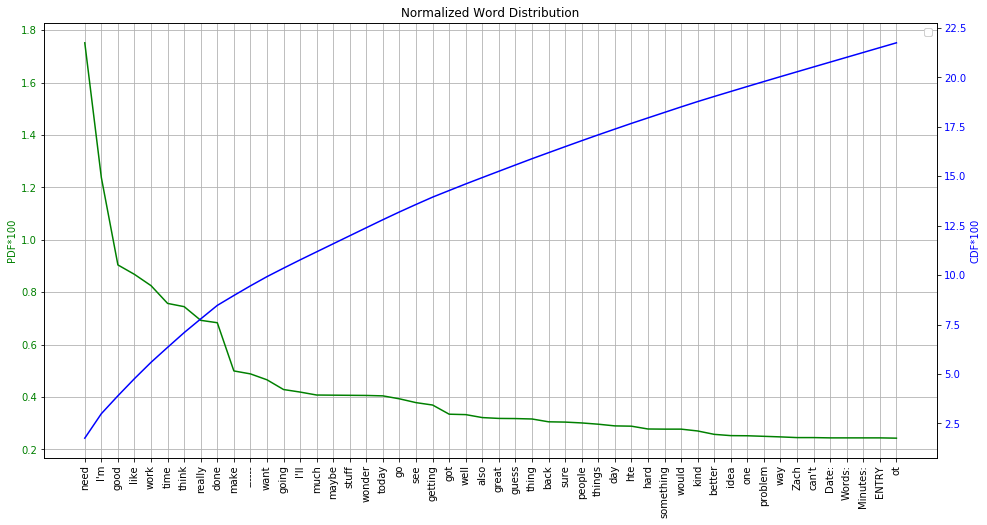

In [5]:
# Same as NLTK FreqDist, except normalized, includes cumsum, and colors
def GraphWordDistribution(words, title="", skip=0, length=50, includeCDF=True) -> None:
    def GetPDFCDF(words):
        def ToPercent(x: float) -> float:
            return x * 100

        # NOTE: No point creating a full data frame when only using a single column.
        pdf = pd.Series(words).value_counts(normalize=True).apply(ToPercent)
        cdf = pdf.cumsum()
        return (pdf, cdf)

    def PlotOnAxis(series, ax, label, color):
        # RANT: Why is MPL so confusing? The OO interface vs the stateful interface, GRAH!!
        # The random non-obvious calls.
        # GRAH!!!

        ax.legend(label.split())
        ax.plot(series, color=color)

        # RANT: Why no YAxis.set_labal_params()? E.g.
        #                 ax.yaxis.set_label_params(label, color=color)
        ax.set_ylabel(label, color=color)
        ax.yaxis.set_tick_params(labelcolor=color)

        # technically all the X axis paramaters are duplicated since we "twinned the X paramater"
        ax.xticks = range(len(series))

        # RANT: rot can be set on plt.plot(), but not on axes.plot()
        ax.xaxis.set_tick_params(rotation=90)

    # NOTE: can make graph prettier with styles E.g.
    # with plt.style.context("ggplot"):
    fig, ax = plt.subplots(1)

    ax.set_title(title)
    ax.grid(True)

    # make pdf first axes, and cdf second axes.
    ax_pdf, ax_cdf = (ax, ax.twinx())
    color_pdf, color_cdf = ("green", "blue")
    pdf, cdf = GetPDFCDF(words)

    PlotOnAxis(pdf[skip : skip + length], ax_pdf, label="PDF*100", color=color_pdf)
    PlotOnAxis(cdf[skip : skip + length], ax_cdf, label="CDF*100", color=color_cdf)


GraphWordDistribution(words, title="Normalized Word Distribution")

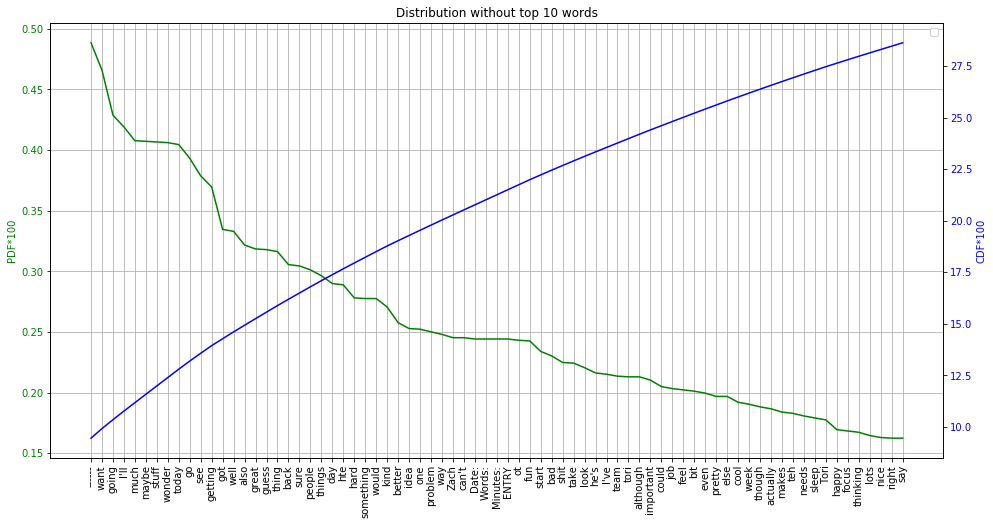

In [6]:
skip = 10
GraphWordDistribution(
    words, skip=skip, length=75, title=f"Distribution without top {skip} words"
)

In [7]:
# wordcloud is non-deterministic, which is bizarre.
# from wordcloud import WordCloud
# wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords=None).generate("".join(words))
# plt.imshow(wordcloud,  interpolation='bilinear')

# Play with POS tagging and lemmatisation

In [12]:
# Load data model:
nlp = spacy.load("en_core_web_lg")  # python -m spacy download en_core_web_lg
nlp.max_length = 20 * 1000 * 1000

# NOTE: Here we use data, which is not cleaned so SPACY can use it to do better POS and NER.
doc = nlp(data)

In [13]:
max_to_analyze = 15
interesting = [token for token in doc if token.tag_ == "NNS"]
for token in interesting[:max_to_analyze]:
    # print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_, token.shape_, token.is_alpha, token.is_stop)
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_)

Words word NOUN NNS ROOT
Minutes minute NOUN NNS appos
allergies allergy NOUN NNS dobj
meds med NOUN NNS dobj
deends deend NOUN NNS dep
alergens alergen NOUN NNS nsubj
allergies allergy NOUN NNS attr
pushups pushup NOUN NNS dobj
trees tree NOUN NNS pobj
houses house NOUN NNS conj
spirits spirit NOUN NNS nsubj
rules rule NOUN NNS pobj
planters planter NOUN NNS dobj
adn adn NOUN NNS nsubj
savings saving NOUN NNS pobj


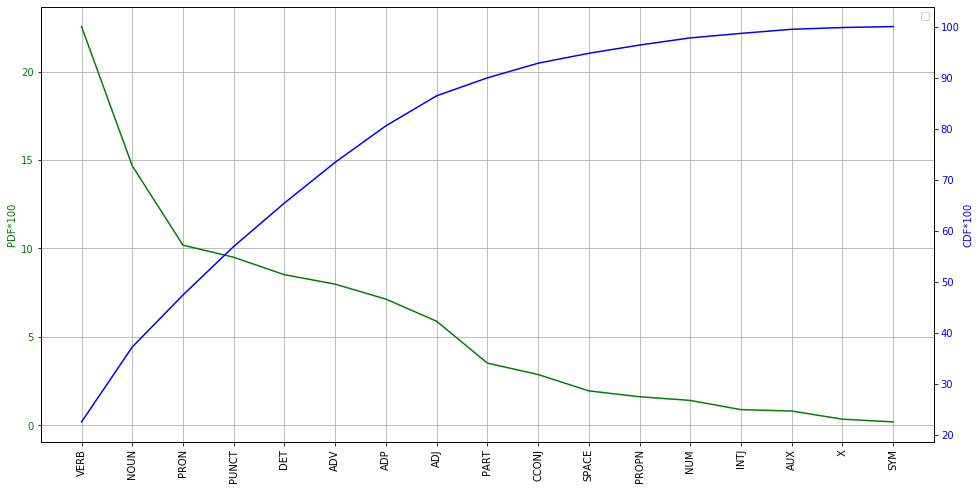

In [22]:
GraphWordDistribution([token.pos_ for token in doc])

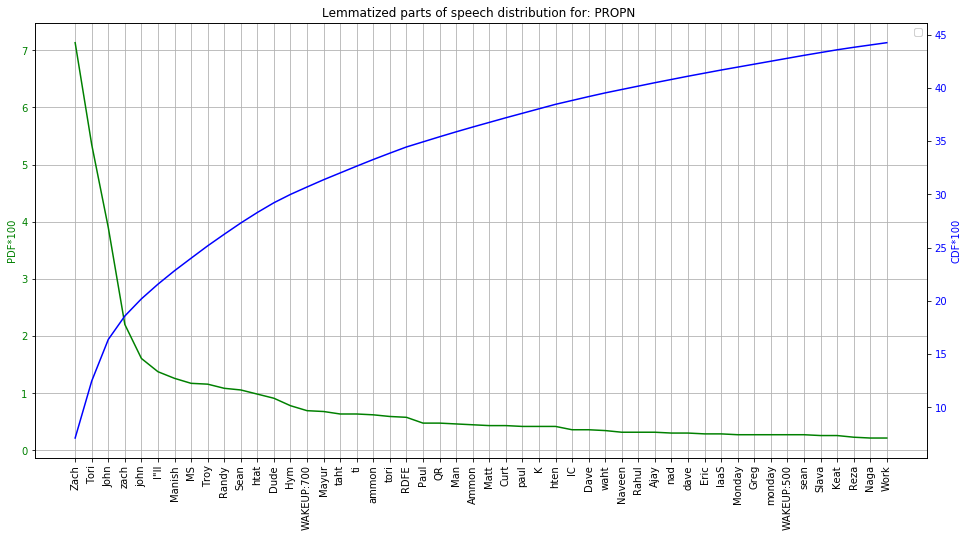

In [20]:
# interesting =  [token for token in  doc]
# Parts of speech: https://spacy.io/usage/linguistic-features
interesting_pos = "PROPN "
# interesting_pos = "NOUN"
interesting_pos_set = set(interesting_pos.split())
interesting = [token for token in doc if token.pos_ in interesting_pos_set]
# interesting = [ token for token in doc if token.pos_ != "PUNCT" and token.pos_ != "SYM" and len(token.text) > 3]
interesting_words = [token.lemma_ for token in interesting]
GraphWordDistribution(
    interesting_words,
    title=f"Lemmatized parts of speech distribution for: {interesting_pos}",
    skip=0,
    length=50,
)